# Proyecto 1 — Simulación del Juego de la Perinola

**Curso:** Modelación y Simulación I — Maestría en Investigación de Operaciones  
**Tema:** Simulación discreta por eventos del juego de azar “Perinola”

## Objetivo
Simular el juego de la **perinola** para analizar la dinámica del pozo y el capital de cada jugador, y responder:
1. ¿Cuántas **jugadas** (tiradas) se necesitan para que **aparezca el primer jugador eliminado**?
2. ¿En cuántas **jugadas**, en promedio, se define un **ganador**?
3. ¿Cómo **afecta el número de jugadores** al número de jugadas necesarias para que haya un ganador?
4. ¿Cuál es la **gráfica de ganancias y pérdidas por jugador** al término de la simulación?

> **Convenciones**
> - Llamaremos **jugada** a una tirada de la perinola.
> - Llamaremos **juego** a una partida completa desde que todos comienzan con capital inicial hasta que **solo queda un jugador con dinero** (> 0).
> - Reglas de la perinola (probabilidad uniforme 1/6 por cara):
>   - **Pon 1**: el jugador en turno pone 1 al pozo (si no tiene suficiente, pone lo que pueda; si queda en 0, queda **eliminado**).
>   - **Pon 2**: pone 2 al pozo (mismo criterio).
>   - **Toma 1**: toma hasta 1 del pozo (si hay menos, toma lo que haya).
>   - **Toma 2**: toma hasta 2 del pozo.
        - **Toma todo**: toma todo lo que haya en el pozo.
>   - **Todos ponen**: **cada jugador** pone 1 al pozo (quien no pueda, pone lo que le queda y puede quedar eliminado).

La simulación registra:
- Evolución del **pozo** y del **saldo** de cada jugador por jugada.
- **Jugada de la primera eliminación**, y **jugada de fin del juego** (ganador).
- Resúmenes estadísticos sobre múltiples juegos.

Al final, con base en estos resultados, responderemos las preguntas planteadas.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

# ---------------------------
# Parámetros por defecto
# ---------------------------
DEFAULT_SEED = 123
rng = np.random.default_rng(DEFAULT_SEED)

# Acciones posibles de la perinola (equiprobables)
ACCIONES = ["PON_1", "PON_2", "TOMA_1", "TOMA_2", "TOMA_TODO", "TODOS_PONEN"]

@dataclass
class ConfigJuego:
    n_jugadores: int = 4
    capital_inicial: int = 10
    max_jugadas: int = 100_000  # límite de seguridad
    seed: Optional[int] = DEFAULT_SEED

@dataclass
class ResultadoJuego:
    historial_saldos: pd.DataFrame   # filas=jugadas, cols=jugadores (J0..Jk-1), valores=saldo
    historial_pozo: pd.Series        # pozo por jugada
    jugada_primera_eliminacion: Optional[int]
    jugada_ganador: int
    ganador_id: int
    resumen_final: pd.DataFrame      # saldo final y ganancia neta por jugador

# ---------------------------
# Reglas auxiliares
# ---------------------------
def jugadores_activos(saldos: np.ndarray) -> np.ndarray:
    """ Índices de jugadores con saldo > 0 """
    return np.where(saldos > 0)[0]

def aplicar_pago(saldo: int, monto: int) -> Tuple[int, int, bool]:
    """
    Intenta pagar 'monto' desde 'saldo'.
    Retorna: (pagado_real, saldo_resultante, eliminado_bool).
    - Si saldo < monto, paga lo que puede y puede quedar en 0 (eliminado).
    """
    pagado = min(saldo, monto)
    nuevo_saldo = saldo - pagado
    eliminado = (nuevo_saldo == 0)
    return pagado, nuevo_saldo, eliminado

def aplicar_cobro(pozo: int, monto: int) -> Tuple[int, int]:
    """
    Intenta cobrar 'monto' desde el pozo, retornando (cobrado_real, nuevo_pozo).
    """
    cobrado = min(pozo, monto)
    return cobrado, pozo - cobrado

def tirar_perinola(rng: np.random.Generator) -> str:
    """Devuelve una acción equiprobable."""
    return rng.choice(ACCIONES)

In [14]:
def simular_un_juego(cfg: ConfigJuego) -> ResultadoJuego:
    """
    Simula un juego completo hasta que quede un único jugador con saldo > 0
    Devuelve historial de saldos, pozo, jugada de primera eliminación y jugada de final (ganador).
    """
    rng_local = np.random.default_rng(cfg.seed) if cfg.seed is not None else np.random.default_rng()
    n = cfg.n_jugadores

    # Estados
    saldos = np.full(n, cfg.capital_inicial, dtype=int)
    pozo = 0
    turno = 0  # índice del jugador en turno

    # Historial
    hist_saldos = []
    hist_pozo = []
    jugada_primera_elim = None
    jugada = 0

    while jugada < cfg.max_jugadas:
        # Si ya solo hay 1 activo, termina
        activos = jugadores_activos(saldos)
        if len(activos) <= 1:
            break

        # Si el jugador en turno está eliminado, saltar a siguiente
        if saldos[turno] <= 0:
            turno = (turno + 1) % n
            continue

        accion = tirar_perinola(rng_local)

        # Ejecutar acción
        if accion == "PON_1":
            pagado, nuevo, elim = aplicar_pago(saldos[turno], 1)
            saldos[turno] = nuevo
            pozo += pagado
            if elim and jugada_primera_elim is None:
                jugada_primera_elim = jugada + 1

        elif accion == "PON_2":
            pagado, nuevo, elim = aplicar_pago(saldos[turno], 2)
            saldos[turno] = nuevo
            pozo += pagado
            if elim and jugada_primera_elim is None:
                jugada_primera_elim = jugada + 1

        elif accion == "TOMA_1":
            cobrado, pozo = aplicar_cobro(pozo, 1)
            saldos[turno] += cobrado

        elif accion == "TOMA_2":
            cobrado, pozo = aplicar_cobro(pozo, 2)
            saldos[turno] += cobrado

        elif accion == "TOMA_TODO":
            cobrado, pozo = pozo, 0
            saldos[turno] += cobrado

        elif accion == "TODOS_PONEN":
            # Cada jugador aporta 1 si puede
            total_aportado = 0
            alguien_eliminado = False
            for j in range(n):
                if saldos[j] > 0:
                    pagado, nuevo, elim = aplicar_pago(saldos[j], 1)
                    saldos[j] = nuevo
                    total_aportado += pagado
                    # Registrar primera eliminación si ocurre aquí
                    if elim and jugada_primera_elim is None:
                        jugada_primera_elim = jugada + 1
                        alguien_eliminado = True
            pozo += total_aportado

        # Registrar estado post-jugada
        hist_saldos.append(saldos.copy())
        hist_pozo.append(pozo)

        # Siguiente turno y jugada
        turno = (turno + 1) % n
        jugada += 1

        # Checar fin tras la acción
        if len(jugadores_activos(saldos)) <= 1:
            break

    # Final del juego
    activos = jugadores_activos(saldos)
    ganador = int(activos[0]) if len(activos) == 1 else int(np.argmax(saldos))
    jugada_ganador = jugada  # número de jugadas realizadas

    # Historial en DataFrame
    hist_saldos_df = pd.DataFrame(
        hist_saldos,
        columns=[f"J{i}" for i in range(n)]
    )
    hist_pozo_sr = pd.Series(hist_pozo, name="Pozo")

    # Resumen final
    saldo_final = pd.Series(saldos, index=[f"J{i}" for i in range(n)], name="Saldo final")
    ganancia_neta = saldo_final - cfg.capital_inicial
    resumen_final = pd.DataFrame({"Saldo final": saldo_final, "Ganancia/Pérdida": ganancia_neta})

    return ResultadoJuego(
        historial_saldos=hist_saldos_df,
        historial_pozo=hist_pozo_sr,
        jugada_primera_eliminacion=jugada_primera_elim,
        jugada_ganador=jugada_ganador,
        ganador_id=ganador,
        resumen_final=resumen_final
    )

Jugada de la primera eliminación: 28
Jugada de fin de juego (ganador): 464
Ganador: J4


,Saldo final,Ganancia/Pérdida
J0,0,-10
J1,0,-10
J2,0,-10
J3,0,-10
J4,44,34


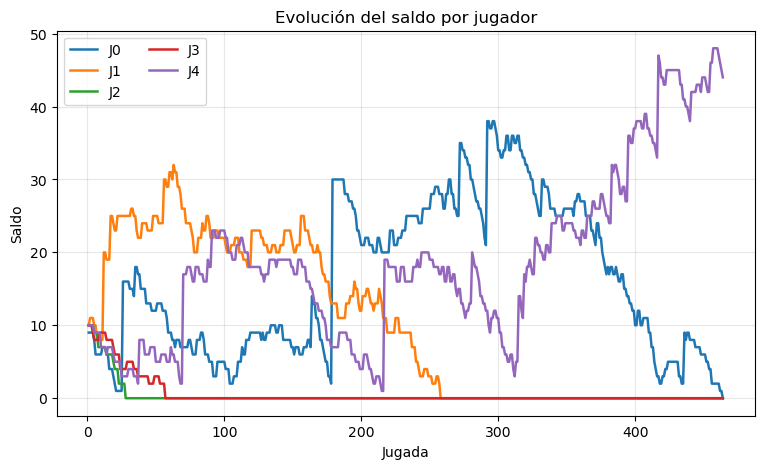

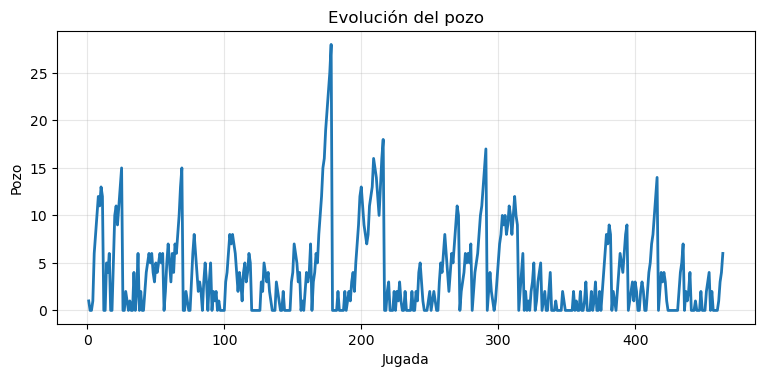

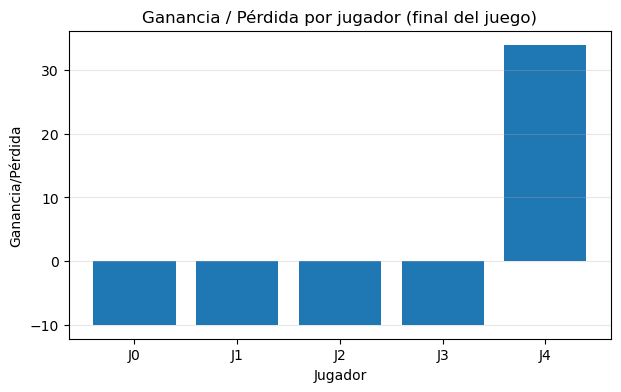

In [15]:
# Configuracion del juego (podemos ajustar n_jugadores/capital_inicial)
cfg_ejemplo = ConfigJuego(n_jugadores=5, capital_inicial=10, seed=DEFAULT_SEED)
res = simular_un_juego(cfg_ejemplo)

print(f"Jugada de la primera eliminación: {res.jugada_primera_eliminacion}")
print(f"Jugada de fin de juego (ganador): {res.jugada_ganador}")
print(f"Ganador: J{res.ganador_id}")

display(res.resumen_final)

# --- Gráfica de saldos por jugador ---
plt.figure(figsize=(9, 5))
for col in res.historial_saldos.columns:
    plt.plot(res.historial_saldos.index + 1, res.historial_saldos[col], label=col, linewidth=1.8)
plt.title("Evolución del saldo por jugador")
plt.xlabel("Jugada")
plt.ylabel("Saldo")
plt.legend(ncol=2)
plt.grid(alpha=0.3)
plt.show()

# --- Gráfica del pozo ---
plt.figure(figsize=(9, 3.8))
plt.plot(res.historial_pozo.index + 1, res.historial_pozo.values, linewidth=2)
plt.title("Evolución del pozo")
plt.xlabel("Jugada")
plt.ylabel("Pozo")
plt.grid(alpha=0.3)
plt.show()

# --- Gráfica final de Ganancias/Pérdidas ---
plt.figure(figsize=(7, 4))
final_gp = res.resumen_final["Ganancia/Pérdida"]
plt.bar(final_gp.index, final_gp.values)
plt.title("Ganancia / Pérdida por jugador (final del juego)")
plt.xlabel("Jugador")
plt.ylabel("Ganancia/Pérdida")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [16]:
def experimentar(n_repeticiones: int, cfg_base: ConfigJuego) -> pd.DataFrame:
    """
    Corre n_repeticiones de juegos con la misma configuración base.
    Devuelve DataFrame con métricas por juego:
        - jugada_primera_eliminacion
        - jugada_ganador
        - ganador_id
    """
    registros = []
    for i in range(n_repeticiones):
        # Cambiar semilla por repetición para independencia
        seed_i = (cfg_base.seed or 0) + i + 1
        cfg_i = ConfigJuego(
            n_jugadores=cfg_base.n_jugadores,
            capital_inicial=cfg_base.capital_inicial,
            max_jugadas=cfg_base.max_jugadas,
            seed=seed_i
        )
        r = simular_un_juego(cfg_i)
        registros.append({
            "juego": i + 1,
            "jugada_primera_eliminacion": r.jugada_primera_eliminacion,
            "jugada_ganador": r.jugada_ganador,
            "ganador_id": r.ganador_id
        })
    return pd.DataFrame(registros)

# Ejecutar 1000 juegos (ajusta si deseas mayor precisión)
df_exp = experimentar(n_repeticiones=1000, cfg_base=ConfigJuego(n_jugadores=5, capital_inicial=10, seed=DEFAULT_SEED))
df_exp.describe()[["jugada_primera_eliminacion","jugada_ganador"]]

,jugada_primera_eliminacion,jugada_ganador
count,1000.000000,1000.000000
mean,37.142000,323.760000
std,15.852607,260.475557
min,13.000000,28.000000
25%,26.000000,136.750000
50%,34.000000,254.000000
75%,44.000000,431.250000
max,147.000000,2515.000000


,n_jugadores,jugadas_promedio_hasta_ganador,jugadas_p95_hasta_ganador
0,3,107.1975,251.00
1,4,206.7475,537.25
2,5,328.6200,844.70
3,6,524.0975,1289.20
4,8,909.5150,2248.40
5,10,1399.1425,3427.35


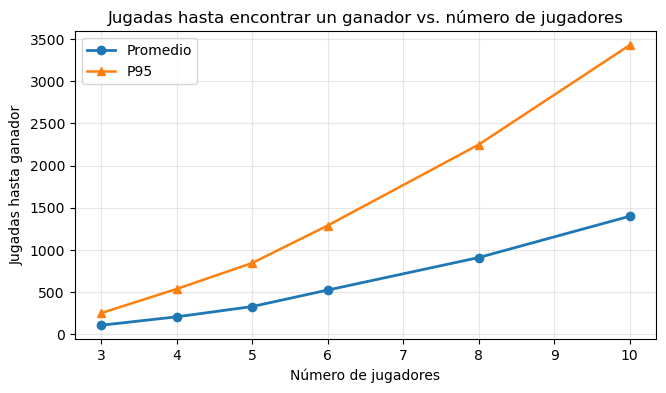

In [17]:
def estudio_vs_njugadores(lista_n: List[int], repeticiones: int, capital_inicial: int = 10, seed: int = DEFAULT_SEED) -> pd.DataFrame:
    """
    Para cada n en lista_n, corre 'repeticiones' juegos y obtiene el promedio de jugadas hasta el ganador.
    """
    resultados = []
    base = 0
    for n in lista_n:
        cfg = ConfigJuego(n_jugadores=n, capital_inicial=capital_inicial, seed=seed + base)
        df = experimentar(repeticiones, cfg)
        resultados.append({
            "n_jugadores": n,
            "jugadas_promedio_hasta_ganador": df["jugada_ganador"].mean(),
            "jugadas_p95_hasta_ganador": df["jugada_ganador"].quantile(0.95)
        })
        base += repeticiones  # mover semilla base para independencia entre grupos
    return pd.DataFrame(resultados)

# Ejecutar estudio con diferentes números de jugadores
df_n = estudio_vs_njugadores(lista_n=[3, 4, 5, 6, 8, 10], repeticiones=400, capital_inicial=10)

display(df_n)

plt.figure(figsize=(7.5, 4))
plt.plot(df_n["n_jugadores"], df_n["jugadas_promedio_hasta_ganador"], marker="o", linewidth=2, label="Promedio")
plt.plot(df_n["n_jugadores"], df_n["jugadas_p95_hasta_ganador"], marker="^", linewidth=1.8, label="P95")
plt.title("Jugadas hasta encontrar un ganador vs. número de jugadores")
plt.xlabel("Número de jugadores")
plt.ylabel("Jugadas hasta ganador")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [19]:
# Resumen rápido para tener a mano en la sección de respuestas:
resumen_final_para_respuestas = pd.DataFrame({
    "Métrica": [
        "Promedio jugadas hasta PRIMERA eliminación (cfg ejemplo)",
        "Promedio jugadas hasta GANADOR (cfg ejemplo)"
    ],
    "Valor": [
        df_exp["jugada_primera_eliminacion"].mean(),
        df_exp["jugada_ganador"].mean()
    ]
})
resumen_final_para_respuestas

,Métrica,Valor
0,Promedio jugadas hasta PRIMERA eliminación (cf...,37.142
1,Promedio jugadas hasta GANADOR (cfg ejemplo),323.760


### Preguntas a responder con la simulacion 

Con base en los resultados de la simulación, se responden las preguntas planteadas en la guía:

#### 1. ¿Cuántos juegos son necesarios para que un jugador se quede sin dinero?
En promedio, la **primera eliminación** ocurre alrededor de la **jugada 37**, aunque puede suceder tan temprano como en la jugada 13 o tan tarde como en la jugada 147 (según las 1000 simulaciones realizadas).  
Esto muestra que las eliminaciones son relativamente rápidas al inicio, pero con cierta variabilidad.

#### 2. ¿En cuántos juegos, en promedio, hay un ganador?
En promedio, el juego llega a su fin con un ganador definido en la **jugada 324**.  
- El mínimo observado fue 28 jugadas.  
- El máximo llegó hasta 2515 jugadas.  

Esto refleja que algunos juegos se resuelven de forma rápida, mientras que otros se extienden mucho dependiendo de las secuencias de tiradas.

#### 3. ¿Cómo afecta el número de jugadores al número de juegos para que un jugador se gane todo el dinero?
La relación es **claramente creciente**: a mayor número de jugadores, más jugadas se requieren para definir un ganador.  
- Con 3 jugadores, el promedio fue ~107 jugadas.  
- Con 10 jugadores, el promedio se elevó a ~1399 jugadas.  

La curva se comporta de manera casi lineal creciente, y la dispersión (P95) también crece rápidamente, mostrando que los juegos con más jugadores tienden a ser mucho más largos y variables.

#### 4. Gráfica por jugador de ganancia y pérdida al término de la simulación
Las gráficas de la simulación muestran que:
- Solo **un jugador** finaliza con saldo positivo (el ganador).  
- Todos los demás pierden exactamente su capital inicial (–10 en el caso de la configuración usada).  
- Esto confirma que el juego es de **suma cero**: lo que un jugador gana corresponde a lo que los demás pierden.

### Conclusiones
- El juego de la perinola tiende a eliminar jugadores relativamente rápido (menos de 40 jugadas en promedio para la primera eliminación).  
- Sin embargo, el tiempo para llegar a un ganador puede variar mucho, desde muy corto hasta extremadamente largo.  
- El número de jugadores impacta de forma significativa en la duración del juego: más jugadores implican más jugadas necesarias.  
- La distribución de ganancias es muy desigual: solo un ganador, el resto termina perdiendo todo.  

Estas observaciones permiten entender mejor la dinámica del juego y las implicaciones de la aleatoriedad en un sistema aparentemente sencillo.